In [2]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

### Reading and preparing data

In [147]:
df = pd.read_csv("data.csv")

How many observations in the dataset?

In [148]:
len(df)

11914

Show several observations from the dataset:

In [149]:
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


The dataset seems to have a couple of issues; the headers are not normalized.
Sometimes they have space and sometimes underscore.

In [150]:
# Make the columns in lower case
df.columns = df.columns.str.lower()

# Replace space with underscore
df.columns = df.columns.str.replace(" ", "_")

Furthermore some of the columns have `objects` as data type although they are technically just `str`.
Let's normalize this as well, make them lower and replace any space with an underscore.

In [151]:
df.dtypes

make                  object
model                 object
year                   int64
engine_fuel_type      object
engine_hp            float64
engine_cylinders     float64
transmission_type     object
driven_wheels         object
number_of_doors      float64
market_category       object
vehicle_size          object
vehicle_style         object
highway_mpg            int64
city_mpg               int64
popularity             int64
msrp                   int64
dtype: object

In [152]:
string_columns = list(df.dtypes[df.dtypes == "object"].index)

In [153]:
for string_col in string_columns:
    df[string_col] = df[string_col].str.lower()
    df[string_col] = df[string_col].str.replace(" ", "_")

In [154]:
df.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,3916,29450
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,3916,34500


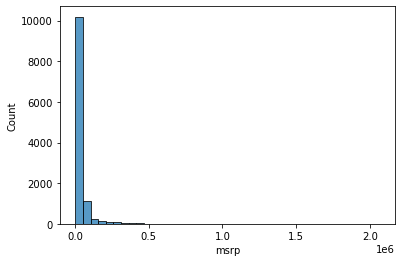

In [155]:
sns.histplot(df.msrp, bins=40);

It seems the target output values distribution has a long tail. The suggested manufacturer retail price gets up to about 2 million USD!

In [156]:
df[df["msrp"] == df["msrp"].max()]

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
11362,bugatti,veyron_16.4,2008,premium_unleaded_(required),1001.0,16.0,automated_manual,all_wheel_drive,2.0,"exotic,high-performance",compact,coupe,14,8,820,2065902


So let's reduce the upper limit, and focus only on cars that cost less than 100'000 USD:

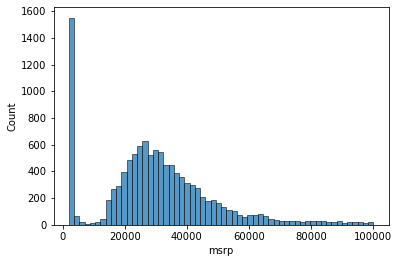

In [157]:
sns.histplot(df.msrp[df.msrp < 1e5]);

_Why does this even matter?_

A long tail distribution confuses your model (scaling issues), the location of data is highly unbalanced.
With some transformation, you can have better distribution of the data.

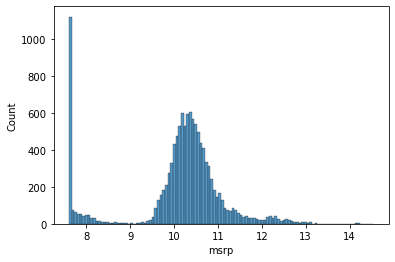

In [158]:
sns.histplot(np.log1p(df.msrp)); # Add 1 to make sure there's no zero value that got log-ed.

In [159]:
np.log(df.msrp.min())

7.600902459542082

How about missing values?

In [160]:
df.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

At least, there isn't missing values for MSRP.

### Validation framework

Let's set up a validation framework based on the following splitt:
- 20% for validation
- 20% for testing
- 60% for training

In [161]:
n = len(df)  # Total number of observations

# The number of splitting
n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

# Shuffle the whole dataset before grabbing them
np.random.seed(2141)    # for reproducibility
idx = np.arange(n)
np.random.shuffle(idx)  # The shuffling happens in-place

df_shuffled = df.iloc[idx]

In [162]:
df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

In [163]:
x = np.arange(10)
np.random.shuffle(x)

Let's take the target variable:

In [164]:
# Directly take the values and transform them
y_train = np.log1p(df_train.msrp.values)
y_val = np.log1p(df_val.msrp.values)
y_test = np.log1p(df_test.msrp.values)

In [165]:
# NOTE: dot notation won't work here
del df_train["msrp"]
del df_val["msrp"]
del df_test["msrp"]

In [77]:
df_train.iloc[10]

make                                         bmw
model                                   6_series
year                                        2016
engine_fuel_type     premium_unleaded_(required)
engine_hp                                  315.0
engine_cylinders                             6.0
transmission_type                      automatic
driven_wheels                   rear_wheel_drive
number_of_doors                              2.0
market_category               luxury,performance
vehicle_size                             midsize
vehicle_style                        convertible
highway_mpg                                   31
city_mpg                                      20
popularity                                  3916
Name: 659, dtype: object

In [80]:
df_train[["engine_hp", "city_mpg", "popularity"]]

,engine_hp,city_mpg,popularity
2295,305.0,17,549
1051,220.0,26,3105
1754,250.0,16,640
10077,100.0,20,535
3762,108.0,30,2031
...,...,...,...
8011,170.0,21,873
6180,190.0,15,549
3975,242.0,16,1439
5930,140.0,22,204


A linear model is a model that has the following form:

$$
y = g(x) = g(x_1, x_2, \ldots, x_M) = w_0 + w_1 x_1 + \ldots + w_M x_M
$$

where $x$ is the feature vector and $y$ is the target output.

Suppose we have the following result:

| $w_0$ | $w_1$ | $w_2$ | $w_3$ |
| ------| ------| -----|-------|
| 7.17 | 0.01 | 0.04 | 0.002 |

A pure Python implementation would be

In [81]:
w = [7.17, 0.01, 0.04, 0.002]

def linear_regression(xi,w):
    result = w[0]
    for j in range(1,len(w)):
        result += xi[j-1] * w[j]
    return result

In [85]:
linear_regression(df_train[["engine_hp", "city_mpg", "popularity"]].iloc[10].values,w)

18.952

In [86]:
np.exp(18.952)

170117511.44334993

In [102]:
np.log1p(np.exp(linear_regression([453, 11, 86], w)) - 1)

12.312

In [94]:
max(y_train)

14.54107797693027

## Where do the weight come from?

In [103]:
 ?np.expm1

In [120]:
def train_linear_regression(xx, y):
    ones = np.ones(xx.shape[0])
    xx = np.column_stack([ones, xx])
    
    # Solve the normal equation
    xx_t_xx = xx.T @ xx
    xx_t_xx_inv = np.linalg.inv(xx_t_xx)
    w = xx_t_xx_inv @ xx.T @ y
    
    return w

In [105]:
def predict_linear_regression(xx, w):
    return w[0] + xx @ w[1:]

## Predicting the price

Let's use the following feature for the linear regression model:

- Engine horse power (`engine_hp`)
- Number of cylinders (`engine_cylinders`)
- Highway mileage (`highway_mpg`)
- City mileage (`city_mpg`)
- Popularity (`popularity`)

In [106]:
base_features = [
    "engine_hp",
    "engine_cylinders",
    "highway_mpg",
    "city_mpg",
    "popularity",
]

df_train_base = df_train[base_features]

In [107]:
df_train_base.head()

,engine_hp,engine_cylinders,highway_mpg,city_mpg,popularity
2295,305.0,6.0,24,17,549
1051,220.0,4.0,35,26,3105
1754,250.0,6.0,21,16,640
10077,100.0,4.0,29,20,535
3762,108.0,4.0,38,30,2031


In [111]:
df_train_base.isnull().sum()

engine_hp           42
engine_cylinders    11
highway_mpg          0
city_mpg             0
popularity           0
dtype: int64

In [114]:
# Replace NA with 0
df_train_base = df_train_base.fillna(0)

In [115]:
xx_train = df_train_base.values

In [121]:
w = train_linear_regression(xx_train, y_train)

In [126]:
y_pred = predict_linear_regression(xx_train, w)

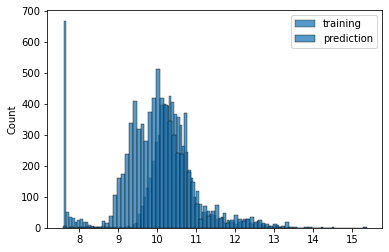

In [128]:
sns.histplot(y_train, label = "training");
sns.histplot(y_pred, label = "prediction");
plt.legend();

In [129]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error**2).mean()
    return np.sqrt(mse)

In [131]:
np.expm1(rmse(y_train, y_pred))

1.094955896136911

In [133]:
df_val_base = df_val[base_features]
df_val_base = df_val_base.fillna(0)
xx_val = df_val_base.values

In [135]:
y_pred = predict_linear_regression(xx_val, w)

In [137]:
rmse(y_pred, y_val)

0.7506700353014587

Let's wrap the preprocessing step in a single function:

In [138]:
def preprocess_xx(df, base_features):
    df_base_features = df[base_features]
    df_base_features = df_base_features.fillna(0)
    xx = df_base_features.values
    return xx

In [141]:
xx_train = preprocess_xx(df_train, base_features)

In [143]:
xx_test = preprocess_xx(df_test, base_features)

In [166]:
y_pred_test = predict_linear_regression(xx_test, w)

In [167]:
rmse(y_pred_test, y_test)

0.8159355560976584

## Simple feature engineering

Add more features to the model to increase its predictive performance:

In [ ]:
df_train["age"] = df_train.year.max() - df_train.year